# Initial

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

DEVICE = "cuda"


import torch, random, numpy as np
from transformers import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(9)

from safetensors import safe_open

import matplotlib.pyplot as plt
import seaborn as sns

# Assign Prompts
All codes are for PyTorch side.

Run the following equivalent commands (select one) for the Kornia-rs side. (Activations are compared via the implicitly saved safetensor files.)
```sh
cargo run -p smol_vlm --features cuda -- -i .vscode/angela-porter-2021-jan-25.jpg -p "Can you describe the image?" --sample-length 500
cargo run -p smol_vlm --features cuda -- -p "A real-valued function f defined on the real line is called an even function if f(-t) = f(t) for each real number t. Prove that the set of even functions defined on the real line with the operations of addition and scalar multiplication defined in Example 3 is a vector space." --sample-length 200
cargo run -p smol_vlm --features cuda -- -p "Can you describe the image?" --sample-length 500 --image-path "/home/ahc/Documents/kornia-rs/examples/smol_vlm/validation_data/angela-porter-2021-jan-25.jpg"
cargo run -p smol_vlm --features cuda -- -p "What is life?" --sample-length 500
```

In [2]:
# image1 = load_image("https://media.istockphoto.com/id/485371557/photo/twilight-at-spirit-island.jpg?s=612x612&w=0&k=20&c=FSGliJ4EKFP70Yjpzso0HfRR4WwflC6GKfl4F3Hj7fk=")
# image2 = load_image("https://huggingface.co/spaces/merve/chameleon-7b/resolve/main/bee.jpg")
# image1 = Image.open("../../../.vscode/fuji-mountain-in-autumn.jpg")
image1 = load_image("https://artwyrd.com/wp-content/uploads/2021/01/angela-porter-2021-jan-25.jpg")
print(f"Image 1 size: {image1.size}")


processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
messages = [
    {
        "role": "user",
        "content": [
            # {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "Can you describe the image?"}
            # {"type": "text", "text": "What is life?"}
            # {"type": "text", "text": "A real-valued function f defined on the real line is called an even function if f(-t) = f(t) for each real number t. Prove that the set of even functions defined on the real line with the operations of addition and scalar multiplication defined in Example 3 is a vector space."}
        ]
    },
]

Image 1 size: (900, 900)


# Activation introspection

In [3]:
from collections import OrderedDict
from activation_introspector import ActivationIntrospector

# Initialize model directly on CUDA without Flash Attention
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16,
    # _attn_implementation="flash_attention_2",  # Commented out Flash Attention
    device_map="cuda",
)
model.eval()



act_isp = ActivationIntrospector()
layers = OrderedDict()

layers["input_embeddings"] = model.get_input_embeddings()
for i in range(24):
    layers[f"input_layernorm_d{i}"] = model.model.text_model.layers[i].input_layernorm
    layers[f"self_attn_d{i}"]       = model.model.text_model.layers[i].self_attn
    layers[f"post_layernorm_d{i}"]  = model.model.text_model.layers[i].post_attention_layernorm
    #  layer[f"mlp_d{i}"]             = model.model.text_model.layers[i].mlp
    layers[f"mlp_gate_proj_d{i}"]   = model.model.text_model.layers[i].mlp.gate_proj
    layers[f"mlp_up_proj_d{i}"]     = model.model.text_model.layers[i].mlp.up_proj
    layers[f"mlp_down_proj_d{i}"]   = model.model.text_model.layers[i].mlp.down_proj
    layers[f"mlp_act_fn_d{i}"]      = model.model.text_model.layers[i].mlp.act_fn
    layers[f"layers_d{i}"]          = model.model.text_model.layers[i]
layers["logits"] = model.get_output_embeddings()

act_isp.set_introspector(layers)



act_isp_vision = ActivationIntrospector()
layers_vision = OrderedDict()

layers_vision["patch_embeddings"] = model.model.vision_model.embeddings.patch_embedding
layers_vision["position_embeddings"] = model.model.vision_model.embeddings.position_embedding
for i in range(27):
    layers_vision[f"input_layernorm_d{i}"] = model.model.vision_model.encoder.layers[i].layer_norm1
    layers_vision[f"self_attn_d{i}"]       = model.model.vision_model.encoder.layers[i].self_attn
    layers_vision[f"post_layernorm_d{i}"]  = model.model.vision_model.encoder.layers[i].layer_norm2
    layers_vision[f"mlp_act_fn_d{i}"]   = model.model.vision_model.encoder.layers[i].mlp.activation_fn
    layers_vision[f"fc1_d{i}"]     = model.model.vision_model.encoder.layers[i].mlp.fc1
    layers_vision[f"fc2_d{i}"]   = model.model.vision_model.encoder.layers[i].mlp.fc2
layers_vision[f"post_layernorm"]          = model.model.vision_model.post_layernorm

act_isp_vision.set_introspector(layers_vision)

type(model)

transformers.models.idefics3.modeling_idefics3.Idefics3ForConditionalGeneration

In [4]:
model

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_

# Generation

In [5]:
act_isp.clear()
act_isp_vision.clear()

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
# inputs = processor(text=prompt, return_tensors="pt")
inputs = inputs.to("cuda")

print(inputs["input_ids"])
# Generate outputs
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=500,
        # repition_penalty=1.1,  # Apply repeat penalty
        output_scores=True,           # Return logits for each generated token
        return_dict_in_generate=True, # Return detailed output object
        do_sample=False,  # Use greedy decoding (highest logit)
    )

outputs.sequences[0]

tensor([[    1, 11126,    42,  ...,  9519,  9531,    42]], device='cuda:0')


tensor([    1, 11126,    42,  ...,    33,    30, 49154], device='cuda:0')

In [6]:
processor.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

'User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>\n<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>\n<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>\n<row_4_col_1><row_4_col_2><row_4_col_3><row_4_col_4>\n\n<global-img>Can you describe the image?\nAssistant: The image features a detailed and intricate design, which appears to be a circular pattern. The central part of the design consists of a large, circular motif, which is composed of numerous interconnected elements. The central part is composed of a series of interconnected leaf-like shapes, each with a unique and detailed design. These leaf-like shapes are arranged in a circular pattern, creating a sense of depth and complexity.\n\nThe background of the design is filled with a dark green color, which provides a stark contrast to the lighter green and white elements of the central motif. The dark green background enhances the visual impact of the intricate patterns and designs within the central motif.\n\nThe image 

# Validation

In [39]:
(model.model.vision_model.encoder.layers[0].layer_norm1.weight,
 model.model.vision_model.encoder.layers[0].layer_norm1.bias)

(Parameter containing:
 tensor([ 3.8086e-01, -4.6997e-03,  8.5938e-02,  ...,  1.6250e+00,
          1.2402e-01,  1.2360e-03], device='cuda:0', dtype=torch.bfloat16,
        requires_grad=True),
 Parameter containing:
 tensor([-0.0051,  0.0008,  0.0113,  ..., -0.0215,  0.0250, -0.0011],
        device='cuda:0', dtype=torch.bfloat16, requires_grad=True))

In [48]:
with safe_open("/home/ahc/.cache/huggingface/hub/models--HuggingFaceTB--SmolVLM-Instruct/snapshots/81cd9a775a4d644f2faf4e7becff4559b46b14c7/model.safetensors", framework="pt", device="cpu") as f:
    print(f.get_tensor("model.vision_model.encoder.layers.26.layer_norm1.bias"))
    print(
        torch.functional.F.mse_loss(model.model.vision_model.encoder.layers[26].layer_norm1.bias.cuda(),
        f.get_tensor("model.vision_model.encoder.layers.26.layer_norm1.bias").cuda())
    )

tensor([-0.1465,  0.0693, -0.0679,  ...,  0.1631, -0.1406, -0.0183],
       dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16, grad_fn=<MseLossBackward0>)


In [172]:
calc_err = lambda rust, python: (
    torch.nn.functional.mse_loss(rust.squeeze(), python.squeeze()).item(),
    torch.nn.functional.l1_loss(rust.squeeze(), python.squeeze()).item()
)
calc_spatial_err = lambda rust, python: ((rust-python)**2).mean(dim=-1)[:16].reshape(4,4,27,27).permute(0,2,1,3).reshape(4*27,4*27).float()
calc_patch_embed_err = lambda rust, python: ((rust-python)**2).mean(dim=1)[:16].reshape(4,4,27,27).permute(0,2,1,3).reshape(108,108).float()
top_err = lambda rust, python: (rust.argsort(descending=True)[0].item(), python.squeeze().argsort(descending=True)[0].item())
topK_logits = lambda rust, python: (rust.argsort(descending=True)[:15], python.squeeze().argsort(descending=True)[:15])

err_fmt = lambda mse, mae: f"(MSE:{mse:.8f}, MAE:{mae:.8f})"

In [150]:
with safe_open("../validation_data/rust_isp_decoder.safetensors", framework="pt", device="cpu") as f:
    logits_output = act_isp.compare_rust_activations(
        range(200), f, top_err, subset=["logits"]
    )
    for i in range(200):
        top_logits_rust = logits_output[f"logits_i{i}"][0]
        top_logits_python = logits_output[f"logits_i{i}"][1]
        if top_logits_python != top_logits_rust:
            print(f"Mismatch at index {i}: Python top {top_logits_python}, Rust top {top_logits_rust}")
            ind_div = i
            break

    topK_logits_output = act_isp.compare_rust_activations(range(200), f, topK_logits, subset=["logits"])
    all_output = act_isp.compare_rust_activations(range(200), f, calc_err)
    for i in range(max(0,ind_div-3), ind_div+2):
        print(f"[{i:>3}] EMBEDS{err_fmt(*all_output[f"input_embeddings_i{i}"])}  LOGITS{err_fmt(*all_output[f"logits_i{i}"])} ")

        top_logits_rust = topK_logits_output[f"logits_i{i}"][0]
        top_logits_python = topK_logits_output[f"logits_i{i}"][1]
        rust_logits = f.get_tensor(f"logits_i{i}").squeeze().cpu()
        python_logits = act_isp.activations[f"logits_i{i}"].squeeze().cpu()

        print(f"[PYTHON] Logits: {[python_logits[i].item() for i in top_logits_python]}, Tokens: {[processor.tokenizer.decode([i]) for i in top_logits_python]}")
        print(f"         Tokens:", [i.item() for i in top_logits_python])
        print(f"[RUST] Logits: {[rust_logits[i].item() for i in top_logits_rust]}, Tokens: {[processor.tokenizer.decode([i]) for i in top_logits_rust]}")
        print(f"         Tokens:", [i.item() for i in top_logits_rust])


        # for layer_d in [0]:
        for layer_d in range(24):
            layer_fmt = lambda layer: err_fmt(*all_output[f"{layer}_d{layer_d}_i{i}"])

            print(f"    [INPUT LAYERNORM]   {layer_fmt("input_layernorm")}")
            print(f"    [SELF ATTN]         {layer_fmt("self_attn")}")
            print(f"    [POST LAYERNORM]    {layer_fmt("post_layernorm")}")
            # print(f"    [MLP]              {layer_fmt("mlp")}")
            print(f"        [MLP/GATE PROJ] {layer_fmt("mlp_gate_proj")}")
            print(f"        [MLP/ACT FN]    {layer_fmt("mlp_act_fn")}")
            print(f"        [MLP/UP PROJ]   {layer_fmt("mlp_up_proj")}")
            print(f"        [MLP/DOWN PROJ] {layer_fmt("mlp_down_proj")}")
            print(f"[LAYER {layer_d:>2}]        {layer_fmt("layers")}")

Mismatch at index 2: Python top 3004, Rust top 4541
[  0] EMBEDS(MSE:0.00000000, MAE:0.00000000)  LOGITS(MSE:2.31255507, MAE:1.21302438) 
[PYTHON] Logits: [20.625, 16.125, 16.0, 15.75, 15.1875, 15.0, 14.9375, 14.625, 14.1875, 13.375, 13.0, 12.9375, 12.9375, 12.875, 12.8125], Tokens: [' The', ' There', ' Unfortunately', ' In', ' This', ' As', ' An', ' Yes', ' A', ' ###', ' It', ' At', ' Image', ' On', ' ##']
         Tokens: [378, 1385, 8286, 533, 669, 1032, 1117, 9230, 330, 20749, 657, 1814, 9979, 1985, 15530]
[RUST] Logits: [20.375, 19.75, 17.875, 15.125, 14.9375, 14.875, 14.4375, 14.0625, 13.875, 13.4375, 13.375, 13.1875, 13.0, 13.0, 12.8125], Tokens: [' The', ' Unfortunately', ' There', ' This', ' It', ' Yes', ' A', ' As', ' In', ' If', ' To', ' An', ' the', ' ###', ' I']
         Tokens: [378, 8286, 1385, 669, 657, 9230, 330, 1032, 533, 1094, 1626, 1117, 260, 20749, 339]
    [INPUT LAYERNORM]   (MSE:0.00014496, MAE:0.00476074)
    [SELF ATTN]         (MSE:0.00007534, MAE:0.00546265

In [173]:
with safe_open("../validation_data/rust_isp_encoder.safetensors", framework="pt", device="cpu") as f:
    err_result = act_isp_vision.compare_rust_activations(range(1), f, calc_err)
    err_result_spatial = act_isp_vision.compare_rust_activations(
        range(1), f, calc_spatial_err,
        subset=[f"input_layernorm_d{layer_d}" for layer_d in range(27)] + [f"post_layernorm_d{layer_d}" for layer_d in range(27)]
    )
    err_result_patch_embed = act_isp_vision.compare_rust_activations(
        range(1), f, calc_patch_embed_err,
        subset=["patch_embeddings"]
    )

    for i in range(1):
        print(f"============== IMAGE [{i:>3}] ==============")
        print(f"PATCH_EMBEDS{err_fmt(*err_result[f"patch_embeddings_i{i}"])}")
        print(f"POS_EMBEDS{err_fmt(*err_result[f"position_embeddings_i{i}"])}")

        for layer_d in range(27):
            layer_fmt = lambda layer: err_fmt(*err_result[f"{layer}_d{layer_d}_i{i}"])

            print(f"[LAYER {layer_d:>2}]")
            print(f"    [INPUT LAYERNORM]   {layer_fmt("input_layernorm")}")
            print(f"    [SELF ATTN]         {layer_fmt("self_attn")}")
            print(f"    [POST LAYERNORM]    {layer_fmt("post_layernorm")}")
            print(f"        [MLP/FC1]       {layer_fmt("fc1")}")
            print(f"        [MLP/ACT FN]    {layer_fmt("mlp_act_fn")}")
            print(f"        [MLP/FC2]       {layer_fmt("fc2")}")

        print(f"[POST POST LAYERNORM]   {layer_fmt("post_layernorm")}")

============== IMAGE [  0] ==============
PATCH_EMBEDS(MSE:0.00136566, MAE:0.01843262)
POS_EMBEDS(MSE:0.00000000, MAE:0.00000000)
[LAYER  0]
    [INPUT LAYERNORM]   (MSE:0.00282288, MAE:0.01965332)
    [SELF ATTN]         (MSE:0.00512695, MAE:0.02600098)
    [POST LAYERNORM]    (MSE:0.01416016, MAE:0.04931641)
        [MLP/FC1]       (MSE:0.02453613, MAE:0.10449219)
        [MLP/ACT FN]    (MSE:0.00154877, MAE:0.00982666)
        [MLP/FC2]       (MSE:0.00370789, MAE:0.03491211)
[LAYER  1]
    [INPUT LAYERNORM]   (MSE:0.00352478, MAE:0.02795410)
    [SELF ATTN]         (MSE:0.00127411, MAE:0.02014160)
    [POST LAYERNORM]    (MSE:0.00903320, MAE:0.04931641)
        [MLP/FC1]       (MSE:0.01312256, MAE:0.07421875)
        [MLP/ACT FN]    (MSE:0.00057983, MAE:0.00860596)
        [MLP/FC2]       (MSE:0.00166321, MAE:0.02697754)
[LAYER  2]
    [INPUT LAYERNORM]   (MSE:0.00518799, MAE:0.04296875)
    [SELF ATTN]         (MSE:0.00047874, MAE:0.01623535)
    [POST LAYERNORM]    (MSE:0.01843262

# Visualization

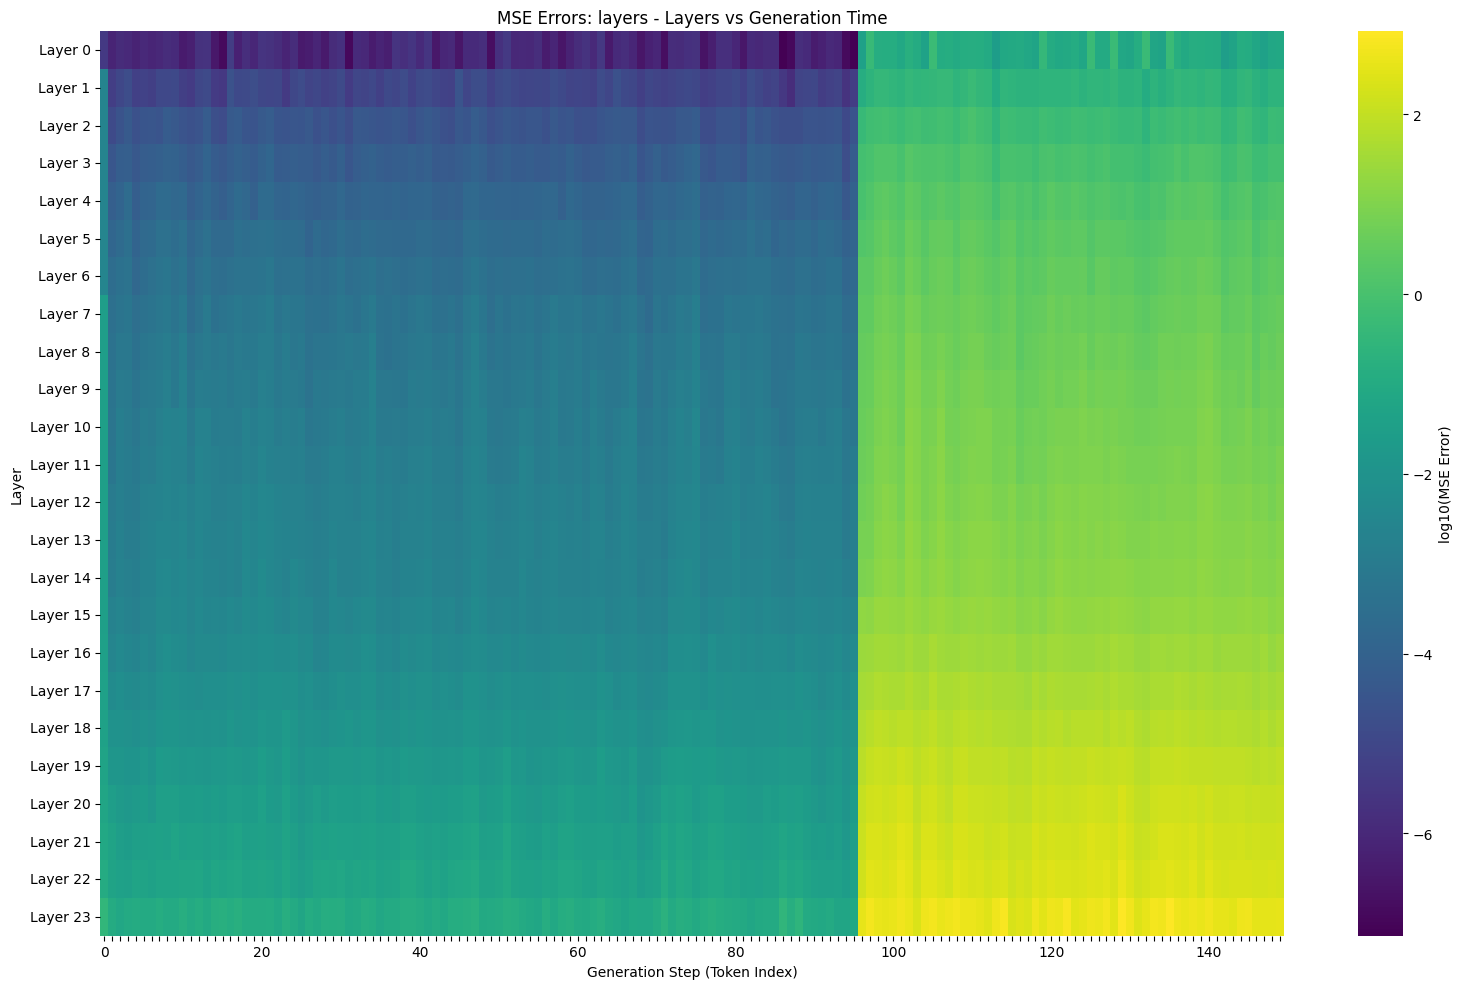

Global log10 error range: [-10.00, 2.92]


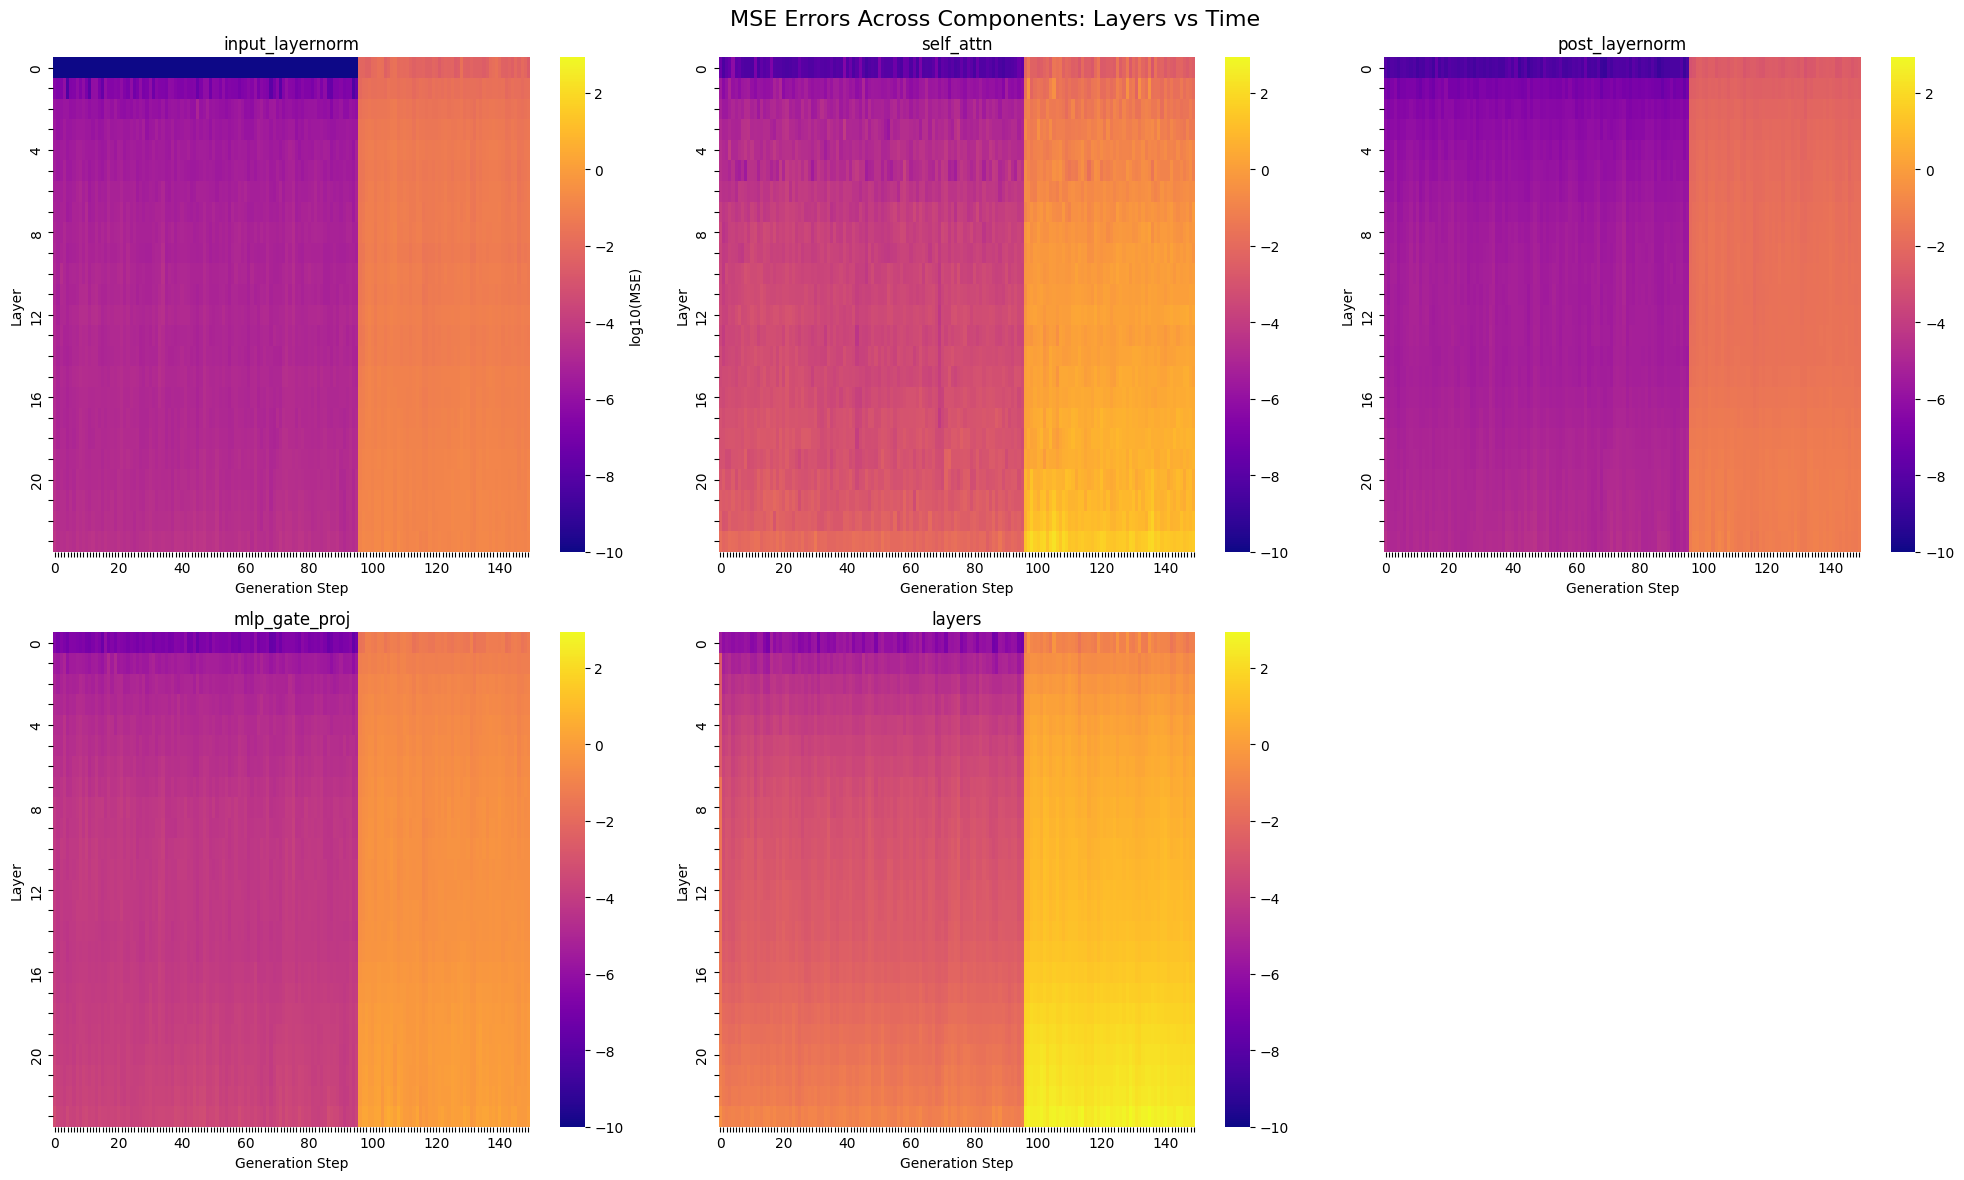

In [27]:
def visualize_layer_time_heatmap(error_type='layers', max_tokens=200, component='layers'):
    """
    Create a heatmap with layers on y-axis and time/tokens on x-axis
    
    Args:
        error_type: 'mse' or 'mae'
        max_tokens: Maximum number of tokens/time steps to show
        component: Which component to visualize ('layers', 'input_layernorm', 'self_attn', etc.)
    """
    layers = 24
    time_steps = min(max_tokens, 200)  # Adjust based on your data
    
    # Initialize error matrix: [layers, time_steps]
    error_matrix = np.zeros((layers, time_steps))
    
    for layer in range(layers):
        for t in range(time_steps):
            error_matrix[layer, t] = all_output[f"layers_d{layer}_i{t}"][0]
    
    # Create the heatmap
    plt.figure(figsize=(16, 10))
    
    # Use log scale for better visualization of small errors
    log_errors = np.log10(error_matrix + 1e-10)  # Add small value to avoid log(0)
    
    sns.heatmap(log_errors,
                cmap='viridis',
                cbar_kws={'label': f'log10({error_type.upper()} Error)'},
                xticklabels=[f'{i}' if i % 20 == 0 else '' for i in range(time_steps)],
                yticklabels=[f'Layer {i}' for i in range(layers)])
    
    plt.title(f'{error_type.upper()} Errors: {component} - Layers vs Generation Time')
    plt.xlabel('Generation Step (Token Index)')
    plt.ylabel('Layer')
    plt.tight_layout()
    plt.show()
    
    return error_matrix

def visualize_multiple_components_over_time(max_tokens=150):
    """
    Create multiple heatmaps for different components showing layer vs time
    with standardized color scale across all subplots
    """
    components = ['input_layernorm', 'self_attn', 'post_layernorm', 'mlp_gate_proj', 'layers']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Collect all error matrices first to determine global min/max
    all_error_matrices = []
    
    for component in components:
        layers = 24
        time_steps = max_tokens
        error_matrix = np.zeros((layers, time_steps))
        
        for layer in range(layers):
            for t in range(time_steps):
                error_matrix[layer, t] = all_output[f"{component}_d{layer}_i{t}"][0]
        
        all_error_matrices.append(error_matrix)
    
    # Calculate global min and max for standardized scale
    all_log_errors = [np.log10(matrix + 1e-10) for matrix in all_error_matrices]
    global_vmin = min(matrix.min() for matrix in all_log_errors)
    global_vmax = max(matrix.max() for matrix in all_log_errors)
    
    print(f"Global log10 error range: [{global_vmin:.2f}, {global_vmax:.2f}]")
    
    # Create heatmaps with standardized scale
    for idx, (component, error_matrix) in enumerate(zip(components, all_error_matrices)):
        if idx >= len(axes):
            break
        
        log_errors = np.log10(error_matrix + 1e-10)
        
        sns.heatmap(log_errors,
                    cmap='plasma',
                    ax=axes[idx],
                    vmin=global_vmin,  # Standardized min
                    vmax=global_vmax,  # Standardized max
                    cbar_kws={'label': 'log10(MSE)'} if idx == 0 else {'label': ''},
                    xticklabels=[f'{i}' if i % 20 == 0 else '' for i in range(max_tokens)],
                    yticklabels=[f'{i}' if i % 4 == 0 else '' for i in range(24)])
        
        axes[idx].set_title(f'{component}')
        axes[idx].set_xlabel('Generation Step')
        axes[idx].set_ylabel('Layer')
    
    # Hide any unused subplots
    for idx in range(len(components), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('MSE Errors Across Components: Layers vs Time', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
error_matrix = visualize_layer_time_heatmap('mse', max_tokens=150, component='layers')
visualize_multiple_components_over_time()

=== Vision Encoder MSE Errors ===
Vision Encoder Error Statistics (MSE):
Min error: 2.88e-04
Max error: 6.00e+01
Mean error: 6.42e-01
Highest error at: fc2 in layer 26 = 6.00e+01


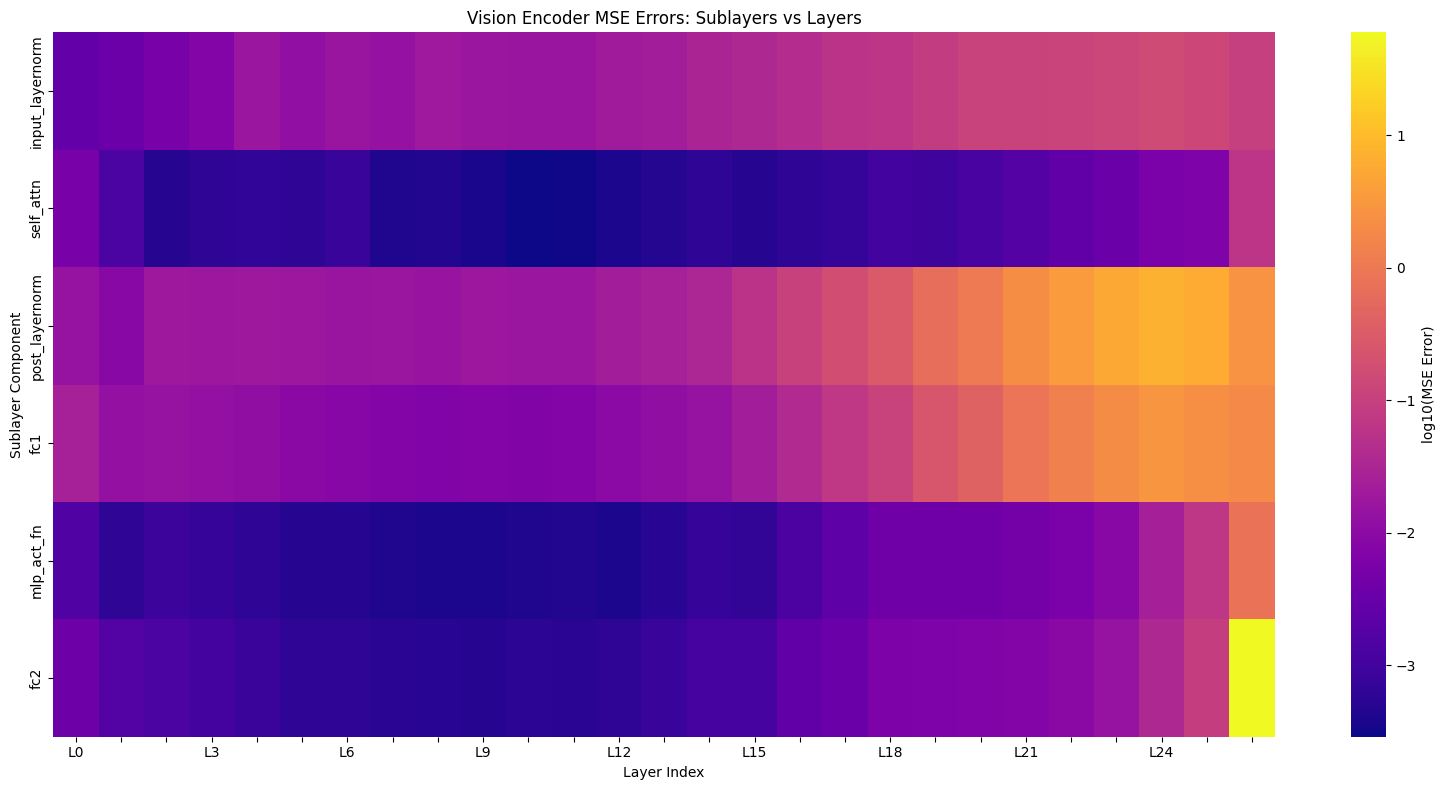


=== Vision Encoder MAE Errors ===
Vision Encoder Error Statistics (MAE):
Min error: 4.18e-03
Max error: 1.85e+00
Mean error: 1.71e-01
Highest error at: post_layernorm in layer 24 = 1.85e+00


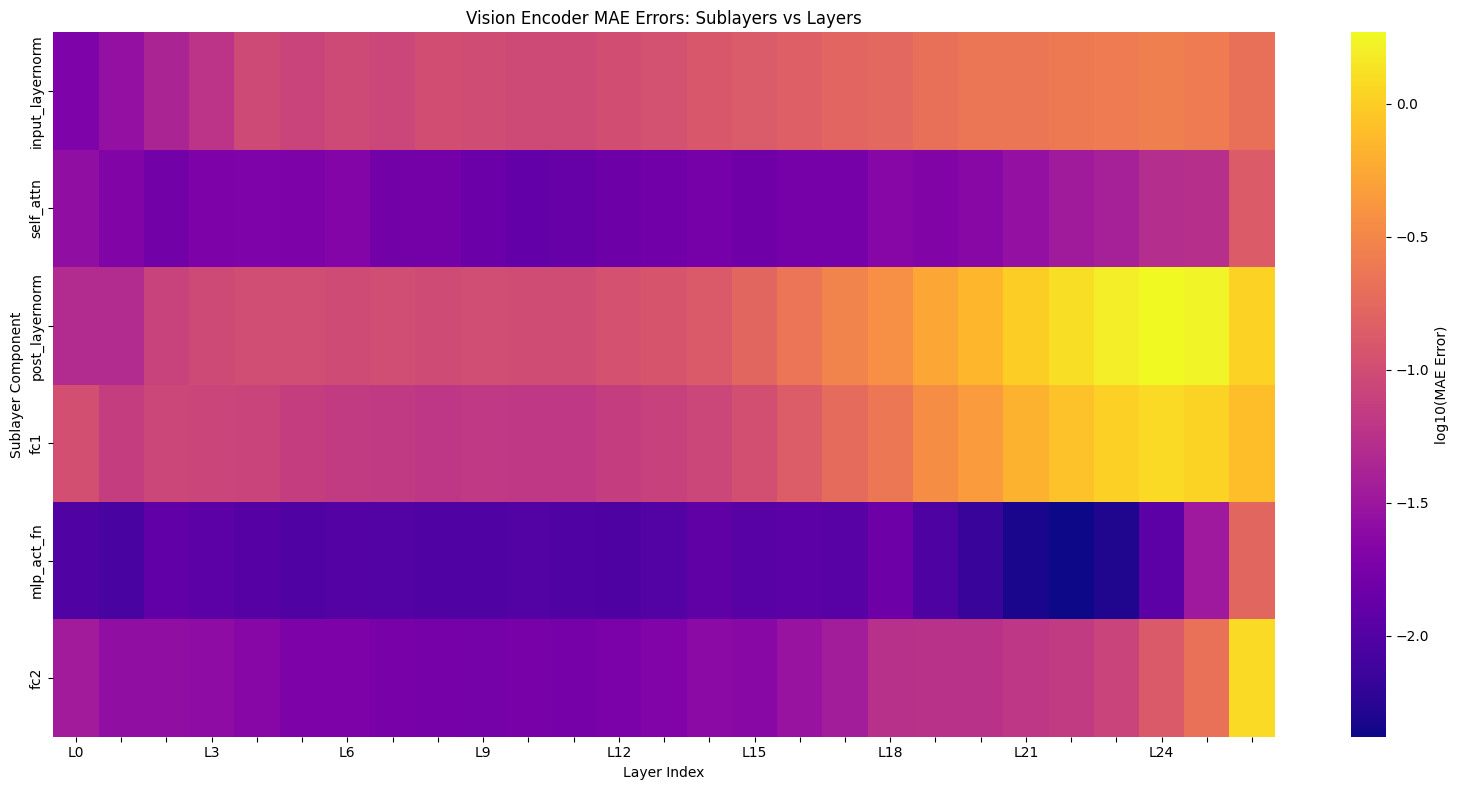


=== Side-by-side Comparison ===


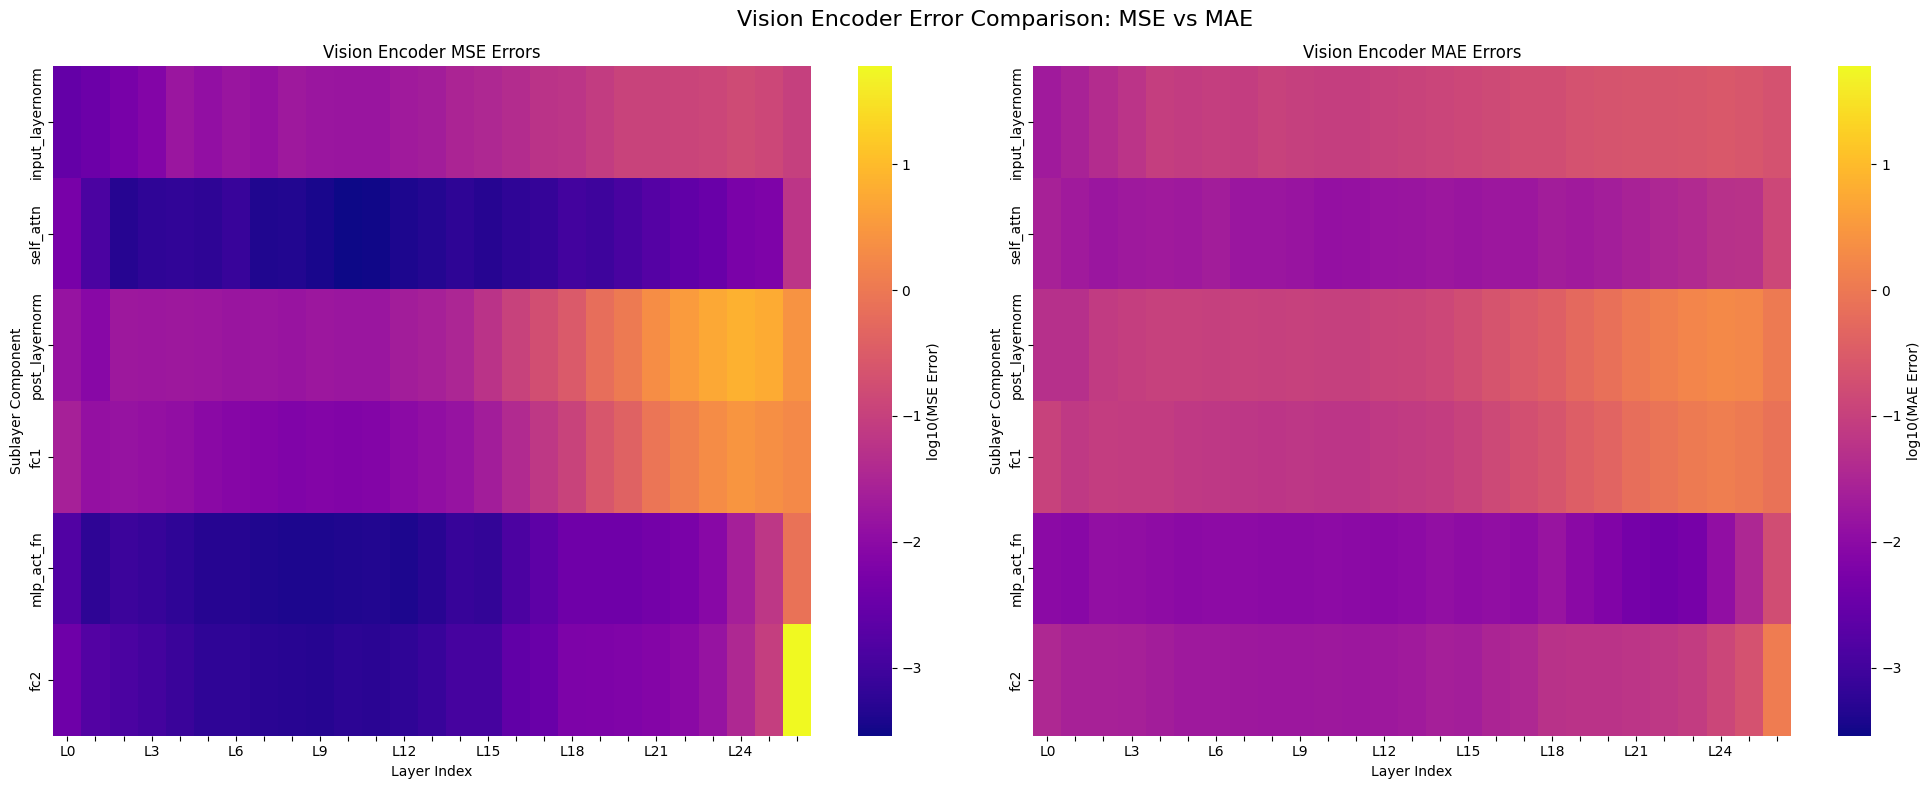

In [25]:
def visualize_vision_encoder_sublayers(error_result, error_type='mse'):
    """
    Create a heatmap for vision encoder errors with layers on x-axis and sublayers on y-axis
    
    Args:
        error_result: Dictionary containing vision encoder error results
        error_type: 'mse' or 'mae' (0 for MSE, 1 for MAE in the tuple)
    """
    num_layers = 27
    
    # Define sublayers for vision encoder
    sublayers = [
        'input_layernorm',
        'self_attn', 
        'post_layernorm',
        'fc1',
        'mlp_act_fn',
        'fc2'
    ]
    
    # Create error matrix: [sublayers, layers]
    error_matrix = np.zeros((len(sublayers), num_layers))
    error_idx = 0 if error_type == 'mse' else 1
    
    # Fill the matrix with error values
    for layer_idx in range(num_layers):
        for sublayer_idx, sublayer in enumerate(sublayers):
            key = f"{sublayer}_d{layer_idx}_i0"  # i0 since vision encoder processes one image
            if key in error_result:
                error_matrix[sublayer_idx, layer_idx] = error_result[key][error_idx]
    
    # Create the visualization
    plt.figure(figsize=(16, 8))
    
    # Use log scale for better visualization
    log_errors = np.log10(error_matrix + 1e-12)  # Add small value to avoid log(0)
    
    # Create heatmap
    sns.heatmap(log_errors,
                cmap='plasma',
                cbar_kws={'label': f'log10({error_type.upper()} Error)'},
                xticklabels=[f'L{i}' if i % 3 == 0 else '' for i in range(num_layers)],
                yticklabels=sublayers,
                annot=False)
    
    plt.title(f'Vision Encoder {error_type.upper()} Errors: Sublayers vs Layers')
    plt.xlabel('Layer Index')
    plt.ylabel('Sublayer Component')
    plt.tight_layout()
    
    # Print some statistics
    print(f"Vision Encoder Error Statistics ({error_type.upper()}):")
    print(f"Min error: {error_matrix.min():.2e}")
    print(f"Max error: {error_matrix.max():.2e}")
    print(f"Mean error: {error_matrix.mean():.2e}")
    
    # Find layers/sublayers with highest errors
    max_pos = np.unravel_index(np.argmax(error_matrix), error_matrix.shape)
    print(f"Highest error at: {sublayers[max_pos[0]]} in layer {max_pos[1]} = {error_matrix[max_pos]:.2e}")
    
    plt.show()
    
    return error_matrix

def visualize_vision_encoder_comparison():
    """
    Create side-by-side comparison of MSE and MAE errors for vision encoder
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    num_layers = 27
    sublayers = [
        'input_layernorm',
        'self_attn', 
        'post_layernorm',
        'fc1',
        'mlp_act_fn',
        'fc2'
    ]
    
    # Create error matrices for both MSE and MAE
    mse_matrix = np.zeros((len(sublayers), num_layers))
    mae_matrix = np.zeros((len(sublayers), num_layers))
    
    for layer_idx in range(num_layers):
        for sublayer_idx, sublayer in enumerate(sublayers):
            key = f"{sublayer}_d{layer_idx}_i0"
            if key in err_result:
                mse_matrix[sublayer_idx, layer_idx] = err_result[key][0]  # MSE
                mae_matrix[sublayer_idx, layer_idx] = err_result[key][1]  # MAE
    
    # Calculate global min/max for consistent color scaling
    mse_log = np.log10(mse_matrix + 1e-12)
    mae_log = np.log10(mae_matrix + 1e-12)
    
    global_vmin = min(mse_log.min(), mae_log.min())
    global_vmax = max(mse_log.max(), mae_log.max())
    
    # MSE heatmap
    sns.heatmap(mse_log,
                cmap='plasma',
                ax=ax1,
                vmin=global_vmin,
                vmax=global_vmax,
                cbar_kws={'label': 'log10(MSE Error)'},
                xticklabels=[f'L{i}' if i % 3 == 0 else '' for i in range(num_layers)],
                yticklabels=sublayers)
    
    ax1.set_title('Vision Encoder MSE Errors')
    ax1.set_xlabel('Layer Index')
    ax1.set_ylabel('Sublayer Component')
    
    # MAE heatmap
    sns.heatmap(mae_log,
                cmap='plasma',
                ax=ax2,
                vmin=global_vmin,
                vmax=global_vmax,
                cbar_kws={'label': 'log10(MAE Error)'},
                xticklabels=[f'L{i}' if i % 3 == 0 else '' for i in range(num_layers)],
                yticklabels=sublayers)
    
    ax2.set_title('Vision Encoder MAE Errors')
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Sublayer Component')
    
    plt.suptitle('Vision Encoder Error Comparison: MSE vs MAE', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return mse_matrix, mae_matrix

# Generate the visualizations
print("=== Vision Encoder MSE Errors ===")
mse_matrix = visualize_vision_encoder_sublayers(err_result, 'mse')

print("\n=== Vision Encoder MAE Errors ===")
mae_matrix = visualize_vision_encoder_sublayers(err_result, 'mae')

print("\n=== Side-by-side Comparison ===")
mse_comp, mae_comp = visualize_vision_encoder_comparison()

In [176]:
err_result_spatial.keys()

odict_keys(['input_layernorm_d0_i0', 'post_layernorm_d0_i0', 'input_layernorm_d1_i0', 'post_layernorm_d1_i0', 'input_layernorm_d2_i0', 'post_layernorm_d2_i0', 'input_layernorm_d3_i0', 'post_layernorm_d3_i0', 'input_layernorm_d4_i0', 'post_layernorm_d4_i0', 'input_layernorm_d5_i0', 'post_layernorm_d5_i0', 'input_layernorm_d6_i0', 'post_layernorm_d6_i0', 'input_layernorm_d7_i0', 'post_layernorm_d7_i0', 'input_layernorm_d8_i0', 'post_layernorm_d8_i0', 'input_layernorm_d9_i0', 'post_layernorm_d9_i0', 'input_layernorm_d10_i0', 'post_layernorm_d10_i0', 'input_layernorm_d11_i0', 'post_layernorm_d11_i0', 'input_layernorm_d12_i0', 'post_layernorm_d12_i0', 'input_layernorm_d13_i0', 'post_layernorm_d13_i0', 'input_layernorm_d14_i0', 'post_layernorm_d14_i0', 'input_layernorm_d15_i0', 'post_layernorm_d15_i0', 'input_layernorm_d16_i0', 'post_layernorm_d16_i0', 'input_layernorm_d17_i0', 'post_layernorm_d17_i0', 'input_layernorm_d18_i0', 'post_layernorm_d18_i0', 'input_layernorm_d19_i0', 'post_layerno

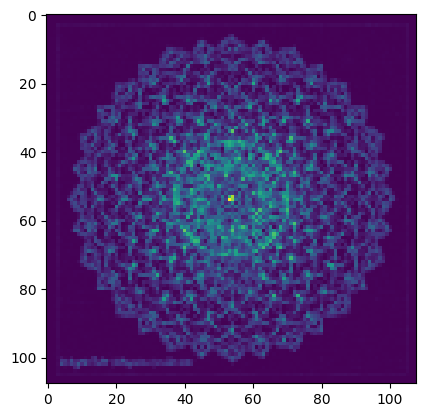

In [ ]:
im = plt.imshow(err_result_patch_embed["patch_embeddings_i0"])
plt.colorbar(im, shrink=0.8)

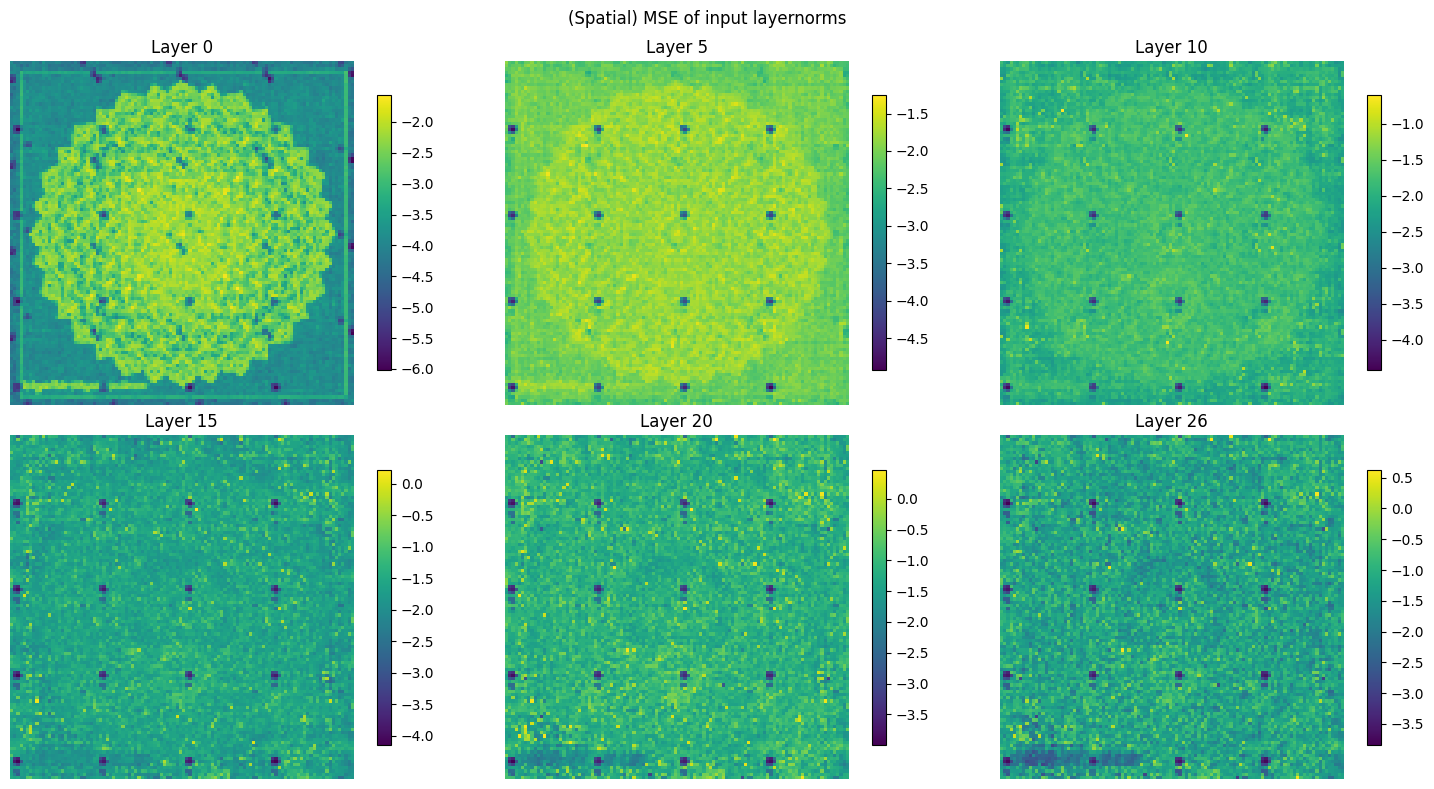

In [151]:
layers_to_show = [0, 5, 10, 15, 20, 26]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_d in enumerate(layers_to_show):
    key = f"input_layernorm_d{layer_d}_i0"
    if key in err_result_spatial:
        im = axes[i].imshow(torch.log10(err_result_spatial[key]))
        axes[i].set_title(f'Layer {layer_d}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.8)


plt.suptitle("(Spatial) MSE of input layernorms")
plt.tight_layout()
plt.show()

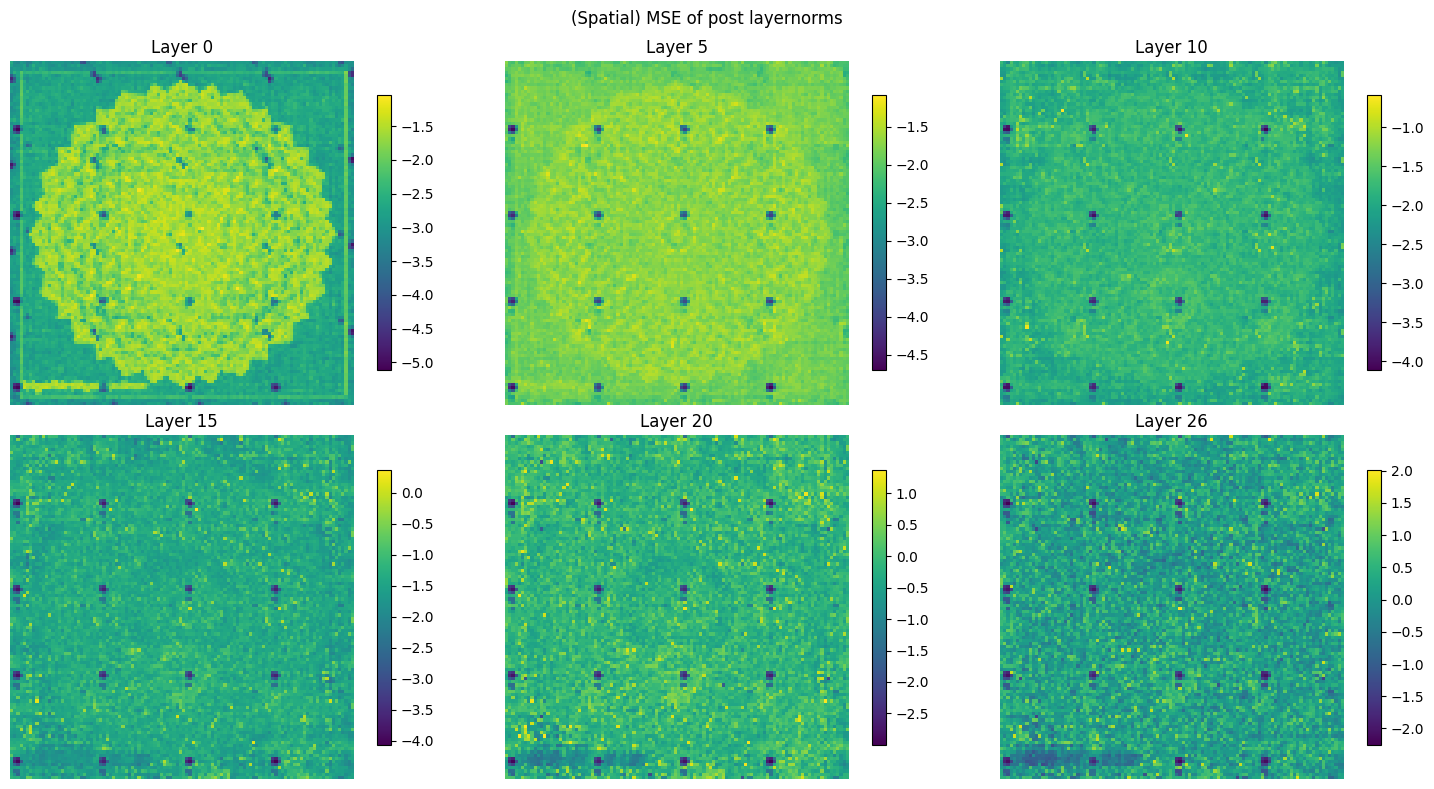

In [152]:
layers_to_show = [0, 5, 10, 15, 20, 26]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_d in enumerate(layers_to_show):
    key = f"post_layernorm_d{layer_d}_i0"
    if key in err_result_spatial:
        im = axes[i].imshow(torch.log10(err_result_spatial[key]))
        axes[i].set_title(f'Layer {layer_d}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.suptitle("(Spatial) MSE of post layernorms")
plt.tight_layout()
plt.show()

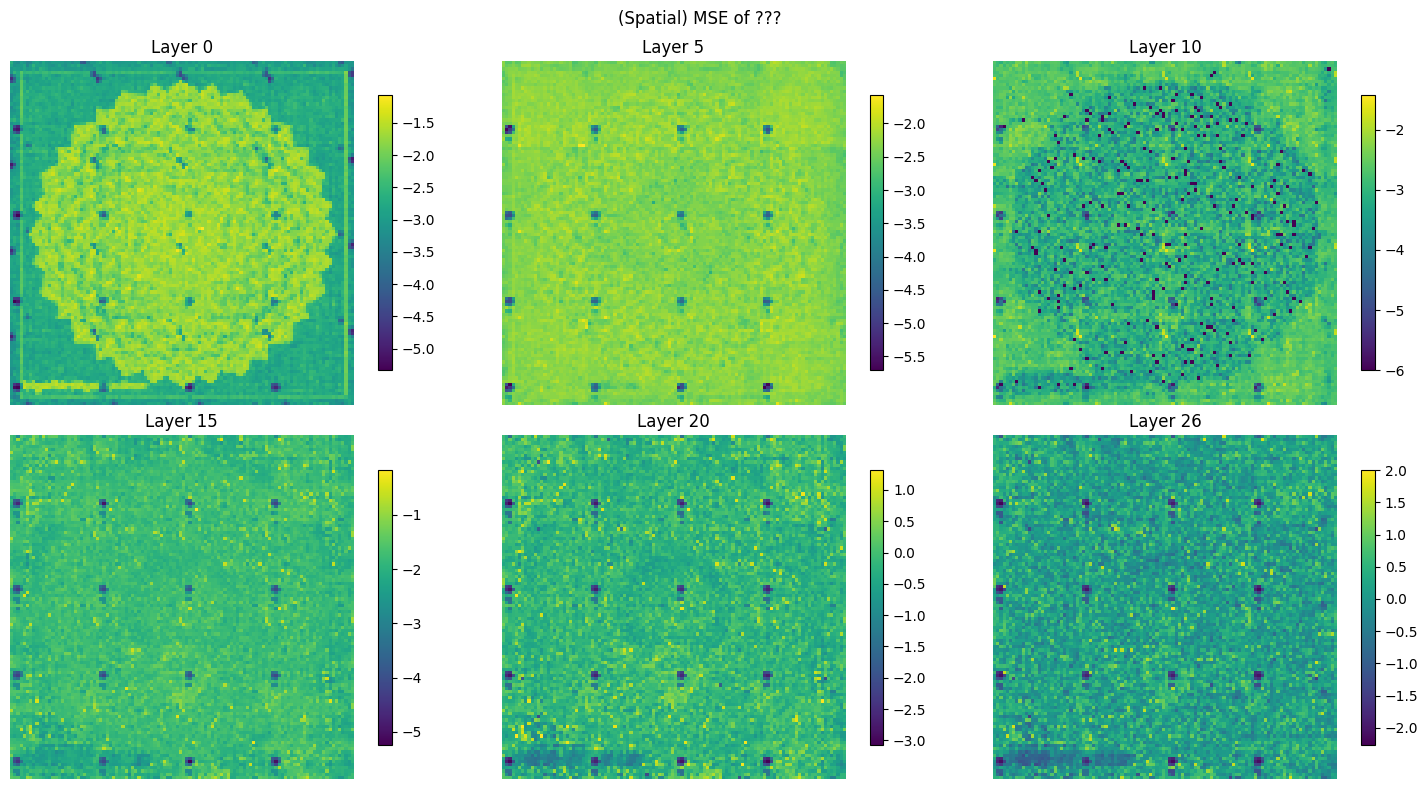

In [153]:
layers_to_show = [0, 5, 10, 15, 20, 26]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_d in enumerate(layers_to_show):
    key = f"input_layernorm_d{layer_d}_i0"
    key2 = f"post_layernorm_d{layer_d}_i0"
    if key in err_result_spatial:
        s = err_result_spatial[key]-err_result_spatial[key2]
        # s = err_result_spatial[key2]
        im = axes[i].imshow(torch.log10(abs(s)+1e-6))
        axes[i].set_title(f'Layer {layer_d}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], shrink=0.8)

plt.suptitle("(Spatial) MSE of ???")
plt.tight_layout()
plt.show()